--- Starting Setup ---
Using device: cuda

Found 10 images in: /kaggle/input/cv-homework-3/samples_q3_q4
--- Setup Complete ---

--- Installing/Verifying Dependencies ---
Dependencies (transformers, Pillow, open_clip_torch) installed/verified.


2025-04-20 09:04:16.697908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745139856.719688     105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745139856.726422     105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



--- Loading BLIP Captioning model: Salesforce/blip-image-captioning-base ---
BLIP Captioning model and processor loaded.

--- Loading Baseline CLIP model: openai/clip-vit-base-patch32 ---
Baseline CLIP model loaded successfully.

--- Loading Enhanced CLIPS model: hf-hub:UCSC-VLAA/ViT-L-14-CLIPS-Recap-DataComp-1B ---
Enhanced CLIPS model, preprocessor, and tokenizer loaded.

--- Processing Images: Generating Captions and Evaluating Similarity ---

Processing: ILSVRC2012_test_00000003.jpg


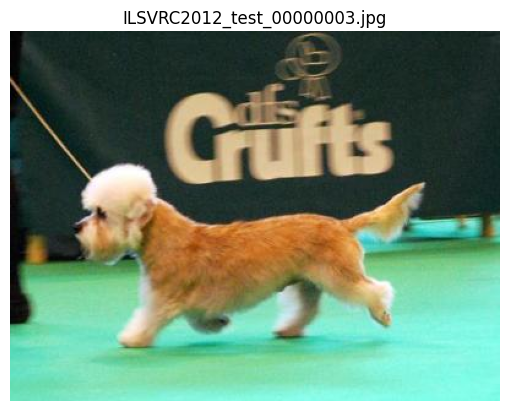

  BLIP Caption: a small dog walking on a green carpet
  CLIP Similarity Score: 31.5660
  CLIPS Similarity Score: 27.0156

Processing: ILSVRC2012_test_00000004.jpg


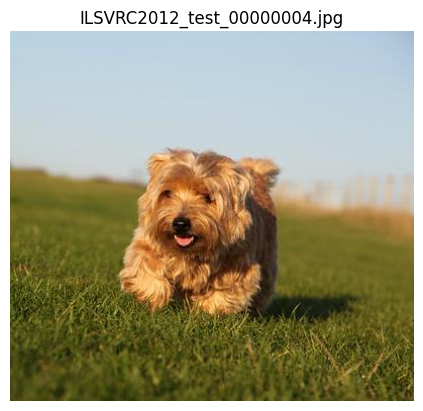

  BLIP Caption: a small dog running across a green field
  CLIP Similarity Score: 32.7026
  CLIPS Similarity Score: 27.7500

Processing: ILSVRC2012_test_00000018.jpg


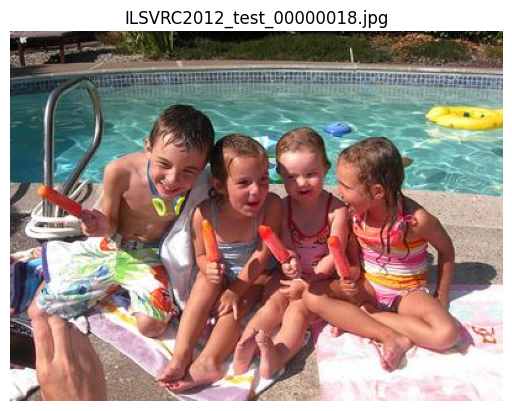

  BLIP Caption: a family sitting in a pool with a towel
  CLIP Similarity Score: 31.3365
  CLIPS Similarity Score: 20.6562

Processing: ILSVRC2012_test_00000019.jpg


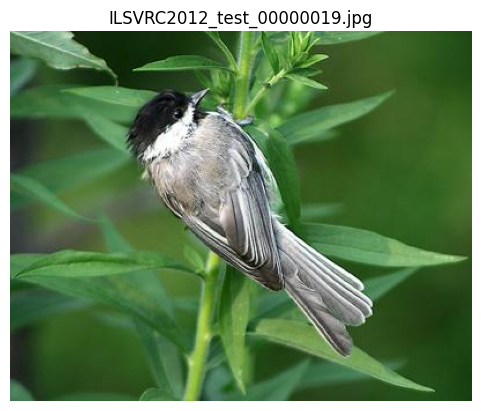

  BLIP Caption: a small bird sitting on a plant
  CLIP Similarity Score: 28.9383
  CLIPS Similarity Score: 24.0625

Processing: ILSVRC2012_test_00000022.jpg


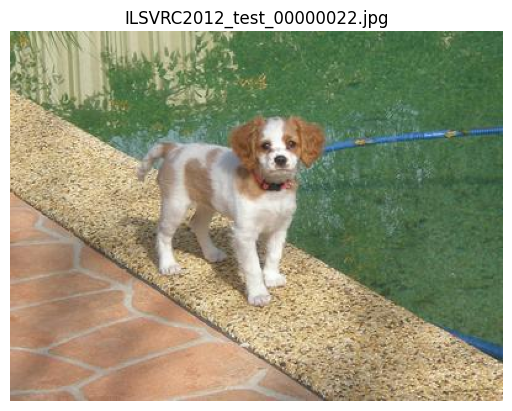

  BLIP Caption: a small dog standing on a stone ledge
  CLIP Similarity Score: 31.0347
  CLIPS Similarity Score: 21.0938

Processing: ILSVRC2012_test_00000023.jpg


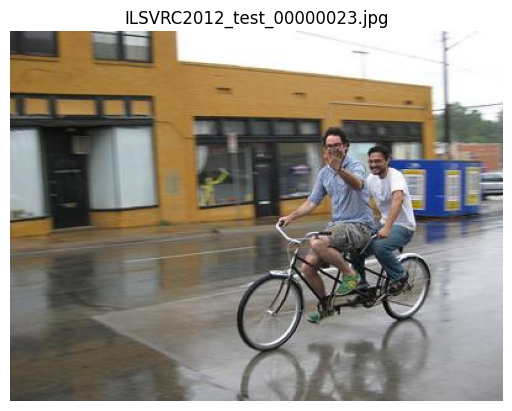

  BLIP Caption: a man riding a bike down a wet street
  CLIP Similarity Score: 30.8345
  CLIPS Similarity Score: 23.0312

Processing: ILSVRC2012_test_00000025.jpg


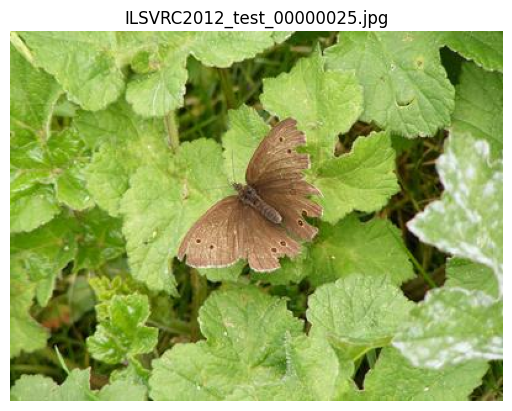

  BLIP Caption: a brown butterfly sitting on a green plant
  CLIP Similarity Score: 28.9163
  CLIPS Similarity Score: 24.0625

Processing: ILSVRC2012_test_00000026.jpg


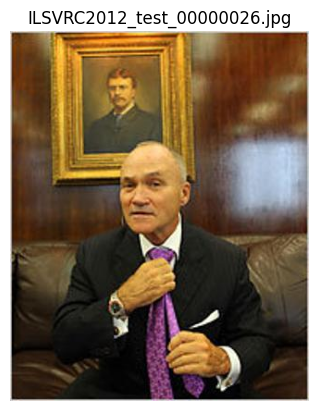

  BLIP Caption: a man in a suit and tie sitting on a couch
  CLIP Similarity Score: 28.8953
  CLIPS Similarity Score: 17.7812

Processing: ILSVRC2012_test_00000030.jpg


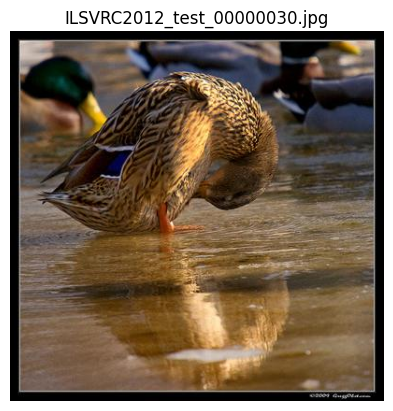

  BLIP Caption: a duck drinking water from a pond
  CLIP Similarity Score: 30.5252
  CLIPS Similarity Score: 23.8906

Processing: ILSVRC2012_test_00000034.jpg


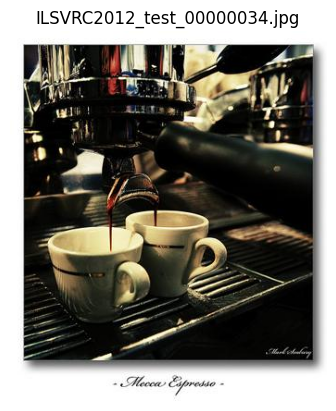

  BLIP Caption: a coffee machine with two cups on it
  CLIP Similarity Score: 27.9613
  CLIPS Similarity Score: 22.7500

--- Image Processing Finished ---
--- Combined Results ---
Image Filename               | Generated BLIP Caption                                       | CLIP Score      | CLIPS Score    
-------------------------------------------------------------------------------------------------------------------------------
ILSVRC2012_test_00000003.jpg | a small dog walking on a green carpet                        | 31.5660         | 27.0156        
ILSVRC2012_test_00000004.jpg | a small dog running across a green field                     | 32.7026         | 27.7500        
ILSVRC2012_test_00000018.jpg | a family sitting in a pool with a towel                      | 31.3365         | 20.6562        
ILSVRC2012_test_00000019.jpg | a small bird sitting on a plant                              | 28.9383         | 24.0625        
ILSVRC2012_test_00000022.jpg | a small dog standing 

In [1]:
print("--- Starting Setup ---")
import torch
import os
import sys
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import torch.nn.functional as F
from glob import glob # To find image files

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
# Input Image Folder Path (Fixed as per requirement)
IMAGE_FOLDER_PATH = "/kaggle/input/cv-homework-3/samples_q3_q4"

# Models to use
BLIP_CAPTION_MODEL_ID = "Salesforce/blip-image-captioning-base" # Or -large
CLIP_SIMILARITY_MODEL_ID = "openai/clip-vit-base-patch32"
CLIPS_SIMILARITY_MODEL_ID = 'hf-hub:UCSC-VLAA/ViT-L-14-CLIPS-Recap-DataComp-1B'

# --- Device Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Warning: Running on CPU. Computations will be slow.")

# --- Find Image Files ---
# Use glob to find common image types in the folder
image_files = glob(os.path.join(IMAGE_FOLDER_PATH, "*.jpg")) + \
              glob(os.path.join(IMAGE_FOLDER_PATH, "*.png")) + \
              glob(os.path.join(IMAGE_FOLDER_PATH, "*.jpeg"))

if not image_files:
    print(f"\nError: No image files (.jpg, .png, .jpeg) found in '{IMAGE_FOLDER_PATH}'.")
    print("Please ensure the input dataset 'cv-homework-3' is added and contains the 'samples_q3_q4' folder with images.")
    assert False, "Input image folder path or content invalid."
else:
    print(f"\nFound {len(image_files)} images in: {IMAGE_FOLDER_PATH}")
    # Sort for consistent order (optional)
    image_files.sort()

print("--- Setup Complete ---")


print("\n--- Installing/Verifying Dependencies ---")
try:
    subprocess.run([sys.executable, "-m", "pip", "install", "transformers", "Pillow", "open_clip_torch", "--quiet"], check=True)
    print("Dependencies (transformers, Pillow, open_clip_torch) installed/verified.")
    # Import necessary libraries after installation
    from transformers import BlipProcessor as BlipCaptionProcessor # Alias to avoid name clash
    from transformers import BlipForConditionalGeneration
    from transformers import CLIPProcessor as ClipSimilarityProcessor # Alias
    from transformers import CLIPModel as ClipSimilarityModel # Alias
    import open_clip
except subprocess.CalledProcessError as e:
    print(f"Error installing dependencies: {e}")
    assert False, "Dependency installation failed."
except ImportError as e:
    print(f"Error importing libraries after attempting installation: {e}")
    assert False, "Dependency import failed."


print(f"\n--- Loading BLIP Captioning model: {BLIP_CAPTION_MODEL_ID} ---")
blip_processor = None
blip_model = None
try:
    blip_processor = BlipCaptionProcessor.from_pretrained(BLIP_CAPTION_MODEL_ID)
    blip_model = BlipForConditionalGeneration.from_pretrained(BLIP_CAPTION_MODEL_ID).to(device)
    blip_model.eval()
    print("BLIP Captioning model and processor loaded.")
except Exception as e:
    print(f"Error loading BLIP Captioning model: {e}")
    assert False, "Failed to load BLIP Captioning model"


print(f"\n--- Loading Baseline CLIP model: {CLIP_SIMILARITY_MODEL_ID} ---")
clip_sim_processor = None
clip_sim_model = None
try:
    clip_sim_processor = ClipSimilarityProcessor.from_pretrained(CLIP_SIMILARITY_MODEL_ID)
    clip_sim_model = ClipSimilarityModel.from_pretrained(CLIP_SIMILARITY_MODEL_ID).to(device)
    clip_sim_model.eval()
    print("Baseline CLIP model loaded successfully.")
except Exception as e:
    print(f"Error loading baseline CLIP model: {e}")
    assert False, "Failed to load baseline CLIP model"


print(f"\n--- Loading Enhanced CLIPS model: {CLIPS_SIMILARITY_MODEL_ID} ---")
clips_sim_model = None
clips_sim_preprocess = None
clips_sim_tokenizer = None
if 'open_clip' in sys.modules:
    try:
        clips_sim_model, clips_sim_preprocess = open_clip.create_model_from_pretrained(CLIPS_SIMILARITY_MODEL_ID)
        clips_sim_model.to(device)
        clips_sim_model.eval()
        clips_sim_tokenizer = open_clip.get_tokenizer(CLIPS_SIMILARITY_MODEL_ID)
        print("Enhanced CLIPS model, preprocessor, and tokenizer loaded.")
    except Exception as e:
        print(f"Error loading CLIPS model from Hub: {e}")
        assert False, "CLIPS model load failed"
else:
     print("Error: open_clip module not available.")
     assert False, "open_clip missing"


print("\n--- Processing Images: Generating Captions and Evaluating Similarity ---")

results_list = [] # To store results for each image

# Check if all models loaded correctly before proceeding
models_loaded = (blip_model and blip_processor and
                 clip_sim_model and clip_sim_processor and
                 clips_sim_model and clips_sim_preprocess and clips_sim_tokenizer)

if not models_loaded:
    print("One or more models failed to load. Cannot proceed with processing.")
else:
    for img_path in image_files:
        print(f"\nProcessing: {os.path.basename(img_path)}")
        img_result = {"image_path": img_path, "caption": None, "clip_score": None, "clips_score": None}

        try:
            # Load and display image
            image_pil = Image.open(img_path).convert('RGB')
            plt.imshow(image_pil)
            plt.title(os.path.basename(img_path))
            plt.axis('off')
            plt.show()

            # --- Part 2: Generate Caption with BLIP ---
            caption = "Error generating caption" # Default
            with torch.no_grad():
                # Prepare image for BLIP captioning
                inputs = blip_processor(images=image_pil, return_tensors="pt").to(device)
                # Generate caption
                generated_ids = blip_model.generate(**inputs, max_length=50)
                # Decode caption
                caption = blip_processor.decode(generated_ids[0], skip_special_tokens=True)
                img_result["caption"] = caption
                print(f"  BLIP Caption: {caption}")


            # --- Part 3: Evaluate with Baseline CLIP ---
            clip_score = float('nan') # Default
            with torch.no_grad():
                 # Prepare inputs for CLIP similarity calculation
                 inputs = clip_sim_processor(text=[caption], images=image_pil, return_tensors="pt", padding=True).to(device)
                 outputs = clip_sim_model(**inputs)
                 # logits_per_image contains the scaled similarity score
                 clip_score = outputs.logits_per_image.item() # Get single score as float
                 img_result["clip_score"] = clip_score
                 print(f"  CLIP Similarity Score: {clip_score:.4f}")


            # --- Part 4: Evaluate with Enhanced CLIPS ---
            clips_score = float('nan') # Default
            enable_autocast = (device == 'cuda')
            with torch.no_grad(), torch.cuda.amp.autocast(enabled=enable_autocast):
                # Prepare image and text for CLIPS
                image_input_clips = clips_sim_preprocess(image_pil).unsqueeze(0).to(device)
                context_length = clips_sim_model.context_length if hasattr(clips_sim_model, 'context_length') else 77
                text_input_clips = clips_sim_tokenizer([caption], context_length=context_length).to(device)

                # Encode, normalize
                image_features = clips_sim_model.encode_image(image_input_clips)
                text_features = clips_sim_model.encode_text(text_input_clips)
                image_features = F.normalize(image_features, dim=-1)
                text_features = F.normalize(text_features, dim=-1)

                # Calculate scaled similarity
                if hasattr(clips_sim_model, 'logit_scale') and isinstance(clips_sim_model.logit_scale, (torch.nn.Parameter, torch.Tensor)):
                    logit_scale = clips_sim_model.logit_scale.exp()
                else:
                    logit_scale = torch.tensor([100.0]).to(device) # Fallback scale

                similarity_logits = (logit_scale * image_features @ text_features.T)
                clips_score = similarity_logits.item() # Get single score as float
                img_result["clips_score"] = clips_score
                print(f"  CLIPS Similarity Score: {clips_score:.4f}")

        except Exception as e:
            print(f"  Error processing image {os.path.basename(img_path)}: {e}")
            # Store error indication in results if needed
            if img_result["caption"] is None: img_result["caption"] = f"Error: {e}"
            if img_result["clip_score"] is None: img_result["clip_score"] = float('nan')
            if img_result["clips_score"] is None: img_result["clips_score"] = float('nan')

        results_list.append(img_result)

    print("\n--- Image Processing Finished ---")


print("--- Combined Results ---")

if results_list:
    # Determine appropriate width for image filename column
    max_len = max(len(os.path.basename(r["image_path"])) for r in results_list) if results_list else 20
    max_len = max(max_len, len("Image Filename")) # Ensure header fits

    # Print Header
    print(f"{'Image Filename':<{max_len}} | {'Generated BLIP Caption':<60} | {'CLIP Score':<15} | {'CLIPS Score':<15}")
    print("-" * (max_len + 60 + 15 + 15 + 9)) # Adjust separator length

    # Print Rows
    for r in results_list:
        img_name = os.path.basename(r["image_path"])
        caption_str = r["caption"] if r["caption"] else "N/A"
        # Truncate long captions for display
        if len(caption_str) > 57: caption_str = caption_str[:57] + "..."

        clip_s = f"{r['clip_score']:.4f}" if isinstance(r['clip_score'], float) and not torch.isnan(torch.tensor(r['clip_score'])) else "Error/NA"
        clips_s = f"{r['clips_score']:.4f}" if isinstance(r['clips_score'], float) and not torch.isnan(torch.tensor(r['clips_score'])) else "Error/NA"

        print(f"{img_name:<{max_len}} | {caption_str:<60} | {clip_s:<15} | {clips_s:<15}")
else:
    print("No results were generated.")

